<a href="https://colab.research.google.com/github/smkerr/tutorial-rag-c/blob/main/Tutorial_RAG_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Retrieval Augmented Generation with Citation (RAG-C)
## GRAD-E1394 Deep Learning -- Assignment 3
Authors:
*   Kai Foerster, k.foerster@students.hertie-school.org
*   Amin Oueslati, a.oueslati@students.hertie-school.org
*   Steven Kerr, s.kerr@students.hertie-school.org


This tutorial offers a step-by-step guide on how to implement Retrieval Augmented Generation with Citation (RAG-C) to address the challenge of knowledge management in government. In essence, RAG-C provides LLMs with additional contextual information through an external data base, which significantly improves response accuracy and avoids hallucinations, particularly on highly domain-specific topics. After showcasing the enhanced performance of RAG-C on a toy example related to coffee prices in Berlin Mitte, this tutorial's focus is the development of a chatbot to answer questions on the US Federal Acquisition Regulation (FAR), the rule book for public procurement issuance in the United States. You will learn how to load and process FAR documents, store them in a data base and build your very own RAG-pipeline. To validate model performance, we leverage a FAR-quiz commonly used for training government employees, which allows us to compare responses from a standard LLM to the RAG-C enhanced LLM. Lastly, this tutorial will show you how to deploy your model as a Conversation User Interface (CUI) on a web server.

An important aspect of this tutorial is its commitment to open-source accessibility, ensuring that all models and frameworks employed are available to everyone. Moreover, the tutorial is designed with computational efficiency in mind. Unlike the resource-heavy process of fine-tuning LLMs, the methods and applications showcased can be comfortably executed on standard laptops. Overall, the tutorial is designed to provide users with clear understanding and a hands-on policy application of how LLM can be augmented to improve their reliability, relevance and privacy conformity, without the need to fall back to paid LLM solutions.  

# Table of Contents

1. [Memo](#memo)
2. [Background & Prerequisites](#background-and-prereqs)
3. [Software Requirements](#software-requirements)
4. [Question-Answer LLM with Hugging Face](#question-answer-LLM)
5. [Loading Data into a Vectorized Database](#vector-db)
6. [RAG Pipeline](#rag-pipeline)
7. [Model Evaluation](#model-evaluation)
8. [Deployment as Conversation User Interface (CUI)](#cui-deployment)
7. [References & Further Resources](#references)


<a id="memo"></a>
# 1. Memo

Poor knowledge management is negatively impacting governments globally. In this regard, the very nature of government is often
inextricably linked to the problem. Firstly, governments are enormous organizations, typically amounting to a country’s single largest employer. Secondly, governments are sparse and complex in their structure, stretching across hundreds of interdependent agencies and sub-agencies. Thirdly, the knowledge in government concerns highly technical matters, which change continuously as new laws are created or existing laws updated.

The detrimental consequences of poor knowledge management in government are multifaceted. Resources are lost, as staff spends up to 20% of its weekly working hours on acquiring internal knowledge (Partnership for Public Service, 2019). Additionally, governments make suboptimal policy decisions, as information is siloed and not accounted for in decision-making processes. One of the most severe examples is 9/11, which likely could have been prevented, had there been better knowledge-sharing across US security agencies (9/11 Commission Report, 2004). Lastly, a state’s legitimacy heavily depends on the adherence to its governing rules: If its officials fail to respect them, due to poor knowledge management, this threatens a government’s democratic foundations.

To tackle poor knowledge management in government, this tutorial introduces Retrieval Augmented Generation with Citations (RAG-C). Essentially, RAG-C is a method for providing Large Language Models (LLMs) with additional contextual information when answering questions. Thus, it is best understood as a conversational chatbot that has access to highly domain-specific knowledge. Importantly, RAG-C outperforms alternative solutions both in terms of trustworthiness and practicability. Firstly, the additional contextual information avoids hallucinations, while the citations enable users to manually validate the responses. Secondly, the RAG-C architecture is compatible with all LLMs, including any in-house models, and allows governments to store the contextual documents on its own servers. Thirdly, compared to fine-tuning the model, updating the data base is much more practical, as it requires limited technical expertise and is computationally inexpensive.





<a id="#background-and-prereqs"></a>
# 2. Background & Prerequisites

A fundamental understanding of machine learning is required for this tutorial. Specifically, the reader should be familiar with LLMs, the vectorization of text data and similarity measures such as cosine similarity.

Retrieval Augmented Generation with Citation (RAG-C) is a sophisticated process that marries the expansive knowledge of a LLM with the precision of targeted information retrieval. The process can be best explained with reference to the illustration below.

The process starts with a user query, in this case the question: “How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?” Without the RAG-C component, this query would directly feed into the LLM which would generate a response (follow the arrows in red). For general knowledge questions or questions that the LLM has encountered during the training process, the responses are usually pretty good. The problem is, that most LLM have not been trained on data that we would like it to know, such as internal data from public institutions, more recent events that happened after the training process of the LLM or in this case the price of a Lebkuchen Latte. When one still insist to ask the LLM about such internal data, recent events or Lattes, it comes up with a false answers that are hallucinated. In scientific language, the question one asked is not in the parametric knowledge of the LLM, and hence the LLM invents knowledge.

With RAG-C in contrast, the parametric knowledge of the LLM is augmented with source knowledge which is saved in a vectorized database. Essentially, we enable the LLM to retrieve additional relevant information beyond its parametric knowledge to answer a question. To understand how exactly the LLM is fed with the most relevant information to answer the question, let us look at the RAG-C pipeline represented in green arrows in the illustration below.

In the RAG-C pipeline, the query is transformed into a numerical representation known as a query vector. This transformation is accomplished through an embedding model, which digests the textual query and outputs a high-dimensional vector that captures its semantic essence. The magic lies in the embedding model's ability to encode the meaning of the text into a mathematical form that can be compared and matched against the vectorized database. The query vector serves as a key to find relevant contexts within this database — contexts that are semantically close to the intent and content of the initial query. To find those texts, text vectors are compared on their similarity score, such as the cosine similarity score, and those contexts with the highest score are retrieved.

The retrieved contexts are then fed to the LLM along with the original query text. This hybrid input, augmented with specific, relevant information, enables the LLM to generate responses that are not only contextually rich but also grounded in the retrieved data. The retrieved sources can further be added as references to the LLM response, bringing the 'C' (citation) element in RAG-C to light.

When executing the code in this tutorial on Google Colab, ensure a smooth experience by downloading the contents of the `data` and `images` folders from the [tutorial repository](https://github.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c) and configuring your folder structure so that it mirrors that of the repository.

In [ ]:
from IPython.display import HTML

# Define the image path and the desired width (as a percentage of the cell width)
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/RAG%2BC_flowchart.jpg'
image_width_percentage = 55  # e.g., 100% of the cell width

# Create and display an HTML image tag with the specified width
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')


<a id="software-requirements"></a>
# 3. Software Requirements
To run the first part of this tutorial up the the deployment in chainlit, it's necessary to have the following libraries installed. For a seamless experience, we suggest using Google Colab equipped with a GPU runtime, as it has most dependencies pre-installed, eliminating the need to configure them.

For executing the notebook locally, it's advisable to have Python version 3.10 installed. One can use pipenv to install all below libraries into a new virtual environment which comes with the benefit that all dependencies are automatically configured by pip. [Here](https://pip.pypa.io/en/latest/) you find more information on how to use pip in case you are interested.

These are the libraries you need to run the notebook:

* langchain
* sentence_transformers
* chromadb
* unstructured
* chainlit
* python-dotenv
* bs4
* tqdm
* pandas
* openpyxl
* scikit-learn
* numpy

Furthermore, one needs to install ipykernel to run the notebook locally.
These libraries can be installed on your local system as well as Colab by executing the subsequent cell (you will need to adapt the code slightly if you use pip).

Please note, the prefix '!' might need to be substituted with '%' in the installation command, depending on your operating system or the configuration of your runtime environment.

In [ ]:
# install dependencies
!pip install  -qqq langchain
!pip install  -qqq sentence_transformers
!pip install  -qqq chromadb
!pip install  -qqq unstructured
!pip install  -qqq chainlit
!pip install  -qqq python-dotenv
!pip install  -qqq bs4
!pip install  -qqq tqdm
!pip install  -qqq pandas
!pip install  -qqq openpyxl
!pip install  -qqq scikit-learn
!pip install  -qqq numpy

Loading .env environment variables...
Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing langchain...
Resolving langchain...
✔ Installation Succeeded
⠋ Installing langchain...
Installing dependencies from Pipfile.lock (d3e772)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
Loading .env environment variables...
Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 t

In [ ]:
# For managing API keys and secrets
import os
from dotenv import load_dotenv

# For loading and manipulating LLMs
from langchain import HuggingFaceHub, PromptTemplate, LLMChain
from langchain.document_loaders import DirectoryLoader

# For loading data, embedding it and storing on ChromaDB
from langchain.vectorstores import Chroma
from bs4 import SoupStrainer
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import BSHTMLLoader
import shutil
import re

# For evaluating the RAG using the quiz
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Integrating images and video in the notebook
from IPython.display import Image
from IPython.display import YouTubeVideo

/Users/steve/.local/share/virtualenvs/dl-tutorial-Si6gq9gB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a name="question-answer-LLM"></a>
# 4. Question & Answer LLM with Hugging Face

This section introduces the application of large language models (LLMs) within the framework provided by Hugging Face. Setting up an operational LLM that the user can interact with is a pre-requiste for building a RAG enhanced LLM.  

Despite the superior performance and ease of integration associated with models from commercial providers such as OpenAI, this notebook utilises Hugging Face, which provides an open-source alternative to state-of-the-art LLMs of commerical providers, which operate on a pay-as-you-go basis. More specifically, this tutorial will rely on the Falcon-7b-instruct model, an open-source model which comes well-balanced in size and performance. The Falcon-7b-instruct, developed by the Technology and Innovation Institute in the UAE, is a 7 billion parameter model fine-tuned for chat and instructions, ensuring high-quality responses [[1]](https://huggingface.co/tiiuae/falcon-7b-instruct).

Employing the Falcon-7b-instruct through HuggingFaceHub eliminates the need for intensive local computing. This approach also circumvents the challenges associated with downloading and operating sizeable models on standard personal computing devices, a process often hindered by substantial working memory requirements.

## Setting Up Hugging Face for Model Integration

First, we need create a Hugging Face API key and save it into a .env file in our root directory. To do so, follow the below instructions:


1. **Creating an Account on Hugging Face**:
To create an account on Hugging Face, visit the [Hugging Face website](https://huggingface.co/join) and click the "Sign Up" button, typically located in the top right corner. Provide your email, and set a password. Follow any additional prompts, such as email verification, to complete your account registration.


In [ ]:
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/Huggingface1.PNG'
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')

2. **Creating an API Key on Hugging Face**:
Once registered, log into your Hugging Face account and access your profile settings. Look for the "API" tab in the settings menu and click it. Here, create a new API key by clicking the “New API token” button, provide a name for the token, and then click “Create a token”. Remember to copy and securely store the generated API key, as it allows access to your Hugging Face account.

In [ ]:
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/Huggingface2.PNG'
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')

3. **Saving the API Key in an .env File**:
Create a new .env file in the root directory of your project using your code editor or IDE. Inside this file, enter the line HF_API_TOKEN=xxxxx, replacing xxxxx with your actual API key. Ensure you save the file after entering this information. If you are working on colab, you will need to upload the .env file to your files.

In [ ]:
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/envfile.PNG'
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')

4. **Loading Environment Variables into the Notebook**:
Now import the load_dotenv function from the dotenv package and call it to load your environment variables. Then, use import os followed by HF_API_TOKEN = os.getenv('HF_API_TOKEN') to access the Hugging Face API token you saved in your .env file. This process makes the API token available in your notebook for further use.

In [ ]:
# Load environment variables from the .env file
load_dotenv()

# Retrieve the 'HF_API_TOKEN' environment variable using os.getenv
# This returns the value of 'HF_API_TOKEN' defined in the .env file
HF_API_TOKEN = os.getenv('HF_API_TOKEN')

## Loading the Hugging Face model in HuggingFaceHub

Next, we specify the name of the model we want to load, provide our API token and make any further configurations to the model. Here, we have set:

* **temperature**: This parameter influences the creativity of the LLM's responses, with a scale ranging from 0 to 1. A higher value results in more inventive outputs. We set this to 0.8, allowing for a degree of unpredictability or 'hallucination' in responses, which is a model behavior we aim to demonstrate to the user.

* **max_lengt**: Defines the maximum length of the model's output, including both the input (such as the question and context) and the generated response. In this case, the limit is set to 1,000 tokens. This setting helps in managing the verbosity and relevance of the model's replies.

* **use_cache**: When set to False, this parameter ensures that the model generates fresh responses for each query rather than relying on previously generated answers stored in cache. This is particularly useful for demonstrating the model's capability to generate unique responses on every run, which is essential for understanding its dynamic nature.

In [ ]:
# Define the ID of the model to be used from Hugging Face Hub
model_id = "tiiuae/falcon-7b-instruct"

# Initialize the HuggingFaceHub class with specified parameters
# huggingfacehub_api_token: Uses the API token stored in the 'HF_API_TOKEN' environment variable
# repo_id: Sets the repository ID to the specified model ID
# model_kwargs: Sets additional parameters for the model as outlined above
conv_model = HuggingFaceHub(
    huggingfacehub_api_token=os.environ['HF_API_TOKEN'],
    repo_id=model_id,
    model_kwargs={"temperature":0.8,"max_length": 1000, "use_cache": False}
)

/Users/steve/.local/share/virtualenvs/dl-tutorial-Si6gq9gB/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


## Prompt Templates and LLMChain


PromptTemplate from LangChain is a tool for creating structured prompts that are used to interact with language models. The structure and content of the prompt are designed to guide the language model in generating specific types of responses.

In the code below, the PromptTemplate is being used to create a template for the language model, in this case, to act as a helpful assistant. The template includes a placeholder {human_message} where the user's query or statement will be inserted.

In [ ]:
# Define a prompt template with a placeholder for user input.
template = """You are a helpful assistant that answers questions of the user.
{human_message}
"""

# Create a PromptTemplate object, specifying 'human_message' as the dynamic input variable.
prompt = PromptTemplate(template=template, input_variables=["human_message"])

This code snippet uses LLMCHain, a langchain function, to "chain" the language model and the prompt together into a pipeline. Using the LLMChain pipeline ensures that the prompt is fed into the LLM in the right way, so that it returns a response. The verbose=True parameter ensures that the function provides detailed output about the process.

In [ ]:
# Create a LLMChain object for a conversational model, using the specified LLM model and prompt template, with verbose logging.
conv_chain = LLMChain(llm=conv_model, prompt=prompt, verbose=True)

## Response Generation

Finally, the code below runs the model chain with a specific question about the cost of a Lebkuchen Latte at Pret a Manger in Berlin Mitte. The run method takes the user's question, inserts it into the {human_message} placeholder in the template, and then feeds the complete prompt to the language model. The model then generates a response based on this prompt, which is printed out.

The choice of an uncommon drink here is intentional, as it aims to reveals a gap in the knowledge of the LLM. Notice that the model gives a fair estimate of how much a Lebkuchen Latte may cost at Pret a Manger in Berlin Mitte, but the price is actually false. Moreover, when rerunning the code several times, the model generates new price estimates. This example shows that the model hallucinates given it does not know the true price. In reality, a Lebkuchen Latte in Pret a Manger in Berlin costs 4.40 Euros.

In [ ]:
# Execute the conversational chain with a specific query and print the response.
print(conv_chain.run("How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?"))



> Entering new LLMChain chain...
Prompt after formatting:
You are a helpful assistant that answers questions of the user.
How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?




> Finished chain.
The price of a Lebkuchen Latte at Pret a Manger in Berlin Mitte is €3.50.


## Providing Relevant Context

Next, to resolve the issue encountered above, we can provide the model with some context about the prices of coffees at Pret a Manger in Berlin Mitte. For this, an excerpt of the menu is added from [Uber Eats](https://www.ubereats.com/de/store/pret-a-manger/t2FefGKTXUavHMqkEDVCVw) below.

First, we paste the excerpt as a multi-line string into a list called llmchain_information. The list is then converted into a single string.

In [ ]:
# List containing the menue of Pret a Manger in Berlin Mitte
llmchain_information = [
   """Hot Drinks & Frappees - Pret A Manger - Berlin Mitte

Latte - 1,5% Milch: 4,60 €
Matcha Latte - Hafer: 5,40 €
Flat White 0,1% Milch: 4,40 €
Chai Latte - 1,5% Milch: 4,90 €
Americano: 3,80 €
Hot Chocolate - 1,5% Milch: 4,60 €
Macchiato - 0,1% Milch: 2,65 €
Espresso: 2,30 €
Hot Chocolate - Hafer: 4,60 €
Pumpkin Spice Latte - 0,1% Milch: 5,40 €
Cappuccino - Hafer: 4,20 €
Chai Latte - Soja: 4,90 €
Espresso Doppio: 3,10 €
Lebkuchen Latte: 4,40 € """
]

# Converts the list of menu items into a single multi-line string.
source_knowledge = "\n".join(llmchain_information)

Next, we adapt our template to add a placeholder for the menu we want to add as context to the prompt.

In [ ]:
# Template string defining the structure for interaction with an assistant, including context and user message.
template_with_context = """You are a helpful assistant that answers questions of the user, using the context provided below.

Contexts:{source_knowledge}

{human_message}
"""

# Creates an instance of PromptTemplate using the defined template and specifying input variables.
prompt2 = PromptTemplate(template=template_with_context, input_variables=["human_message", "source_knowledge"])


Here is the prompt printed out with the context and the question we want to ask!

In [ ]:
# Formats and prints the prompt with specific user query and source knowledge context.
print(prompt2.format(human_message="How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?", source_knowledge=source_knowledge))

You are a helpful assistant that answers questions of the user, using the context provided below.

Contexts:Hot Drinks & Frappees - Pret A Manger - Berlin Mitte

Latte - 1,5% Milch: 4,60 €
Matcha Latte - Hafer: 5,40 €
Flat White 0,1% Milch: 4,40 €
Chai Latte - 1,5% Milch: 4,90 €
Americano: 3,80 €
Hot Chocolate - 1,5% Milch: 4,60 €
Macchiato - 0,1% Milch: 2,65 €
Espresso: 2,30 €
Hot Chocolate - Hafer: 4,60 €
Pumpkin Spice Latte - 0,1% Milch: 5,40 €
Cappuccino - Hafer: 4,20 €
Chai Latte - Soja: 4,90 €
Espresso Doppio: 3,10 €
Lebkuchen Latte: 4,40 € 

How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?



Next, we adapt the LLMChain to use the new prompt we just created!

In [ ]:
# Initializes an LLMChain with a LLM  and the specified prompt template, enabling verbose output.
context_chain = LLMChain(llm=conv_model, prompt=prompt2, verbose=True)

Finally, the code below runs the model chain with a specific question about the cost of a Lebkuchen Latte at Pret a Manger in Berlin Mitte with the menu as context. The resulting response of the model is spot on!

What we have done conceptually by providing further context to the model is that we have augumented the parametric knowledge of the LLM with source knowledge. And what we have implemented manually for a specific questions, can be scaled up to thousands of documents when we use a RAG pipeline.

The important concept to remember as we explain the more complex RAG pipeline next, is that, in essence, we are doing nothing more but providing the LLM with relevant source knowledge to augment its parametric knowledge as we are doing in the simple example about coffee prices at Pret a Manger in Berlin Mitte.

In [ ]:
# Executes the LLMChain with provided context and user message, and prints the result.
print(context_chain.run({
  'source_knowledge': source_knowledge,
  'human_message': "How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?"
}))



> Entering new LLMChain chain...
Prompt after formatting:
You are a helpful assistant that answers questions of the user, using the context provided below.

Contexts:Hot Drinks & Frappees - Pret A Manger - Berlin Mitte

Latte - 1,5% Milch: 4,60 €
Matcha Latte - Hafer: 5,40 €
Flat White 0,1% Milch: 4,40 €
Chai Latte - 1,5% Milch: 4,90 €
Americano: 3,80 €
Hot Chocolate - 1,5% Milch: 4,60 €
Macchiato - 0,1% Milch: 2,65 €
Espresso: 2,30 €
Hot Chocolate - Hafer: 4,60 €
Pumpkin Spice Latte - 0,1% Milch: 5,40 €
Cappuccino - Hafer: 4,20 €
Chai Latte - Soja: 4,90 €
Espresso Doppio: 3,10 €
Lebkuchen Latte: 4,40 € 

How much does a Lebkuchen Latte cost at Pret a Manger in Berlin Mitte?


> Finished chain.
4,40 €


<a name="vector-db"></a>
# 5. Loading Data into a Vectorized Database

<a name="data-description"></a>
# Data Description

In this tutorial, we will build a RAG-C model capable of providing information on the Federal Acquisition Regulation (FAR) system which governs how U.S. government officials buy supplies and services. Our source data consists entirely of HTML files downloaded from [acquisition.gov](https://www.acquisition.gov/browse/index/far) where each HTML file represents a section or sub-section of the FAR regulations. In total, these HTML functions represent over 2,000 pages of rules and regulations consisting of nearly 4,000 separate subdivisions. Each subdivision comes with its own index (e.g., FAR 25.108-2) which codifies information on the precise part, subpart, section, and subsection corresponding with a given text as well as a subdivision title.

This example is relevant to policymakers insofar as it demonstrates how LLMs can be used to provide government officials with accurate and timely information on complex regulations which need to be closely followed. Such a tool would augment the capacities of government officials, facilitate knowledge transfer to new staff, and keep long-time bureaucrats up-to-date on regulatory changes.

## Data Download
To retrieve the necessary data, proceed to [acquisition.gov](https://www.acquisition.gov/browse/index/far), then click on the HTML icon to download all HTML files as a zip file. Unzip this file to load all HTML files on your local device. If you are working on colab, create a new folder under "Files" named "data" and store the HTML files there. Please note that several of the these HTML files only contain metadata which are not immediately relevant to our task (e.g., Table of Contents), so please only keep files that adhere to the index format described above (e.g., "6.204" or "25.108-2").

In [ ]:
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/acquisition_gov.png'
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')

## Data Preprocessing

Once the HTML files have been saved locally, we can proceed to the next step: data processing!

### Load documents

We start by loading our HTML documents from the specified directory. We accomplish this by using LangChain's DirectoryLoader to convert the HTML files to LangChain Document objects which have properties we will leverage in subsequent steps. Note that we pass additional keyword arguments to the DirectoryLoader, allowing us to extract only paragraph elements from our HTML documents which is the content we are interested in. This has the added benefit of shortening the amount of time needed to load all our documents. In total, we load 3,487 documents, each corresponding to separate subdivisions of the FAR regulations.

In [ ]:
# define path to HTML files
DATA_PATH = "data/html"

# define Beautiful Soup key word args
bs_kwargs = {
    "features": "html.parser",
    "parse_only": SoupStrainer("p") # only extract paragraphs
}

# define Loader key word args
loader_kwargs = {
    "open_encoding": "utf-8",
    "bs_kwargs": bs_kwargs
}

# define Loader
loader = DirectoryLoader(
    path=DATA_PATH,
    glob="*.html",
    loader_cls=BSHTMLLoader,
    loader_kwargs=loader_kwargs,
    show_progress=True
    )

# load docs
documents = loader.load()

# status message
print(f"Loaded {len(documents)} documents.")

  4%|▍         | 153/3487 [00:00<00:04, 759.65it/s]

100%|██████████| 3487/3487 [00:04<00:00, 717.39it/s]

Loaded 3487 documents.


Next, we implement some simple data cleaning procedures by removing line breaks, tabs, and excessive whitespace in order to (1) improve the appearance of the formatted text and (2) prevent excessive whitespace from contributing to the character limit of our query (discussed in more detail below). Additionally, we drop the title label from the metadata since we will not be using it in this tutorial.

In [ ]:
# clean up document content
for doc in documents:
    doc.page_content = doc.page_content.replace("\n", " ").replace("\t", " ") # remove line breaks and tabs
    doc.page_content = re.sub("\\s+", " ", doc.page_content) # remove excessive whitespace
    doc.metadata.pop("title") # drop title labels

We can inspect the first document to better understand the underlying structure of LangChain's Document class. Note that each Document consists of two sections: page_content and metadata. The page_content section is quite straightforward since it simply contains the text we just parsed from our HTML files. The metadata section contain a single label identifying the 'source' from which the document was retrieved. While this source label conveniently contains the text's FAR index number, it is formatted as a filepath which may lead to confusion on the part of the user.

In [ ]:
documents[0]

Document(page_content='Warranties of data shall be developed and used in accordance with agency regulations.', metadata={'source': 'data/html/46.708.html'})

### Modify Source Label

A more intuitive way of displaying the source of a given text would be to show the FAR citation as well as the section title. This will tell the user not only where in the FAR to look for further information but also provide a brief description of what the section pertains to so that the user can immediately weigh the relevance of a suggested source. To update our source label, we repeat the process of loading all our documents, however, this time we only extract the titles which contain both the citation and title information. In doing so, we create a list of this information and use it to update the current source labels.

In [ ]:
# define Beautiful Soup key word args
bs_kwargs = {
    "features": "html.parser",
    "parse_only": SoupStrainer("title") # only extract titles
}

# define Loader key word args
loader_kwargs = {
    "open_encoding": "utf-8",
    "bs_kwargs": bs_kwargs
}

loader = DirectoryLoader(
    path=DATA_PATH,
    glob="*.html",
    loader_cls=BSHTMLLoader,
    loader_kwargs=loader_kwargs,
    show_progress=True
    )

document_titles = loader.load()

# convert source metadata into a list
title_list = [doc.metadata["title"] for doc in document_titles]

# update source labels
i = 0
for doc in documents:
    doc.metadata["source"] = " ".join(["FAR", title_list[i]])
    i += 1

100%|██████████| 3487/3487 [00:02<00:00, 1236.47it/s]


We can inspect our work to evaluate whether these source labels are more intuitive.

In [ ]:
doc_metadata = [doc.metadata  for doc in documents]
doc_metadata[:5]

[{'source': 'FAR 46.708 Warranties of data.'},
 {'source': 'FAR 9.405 Effect of listing.'},
 {'source': 'FAR 11.106 Purchase descriptions for service contracts.'},
 {'source': 'FAR 16.204 Fixed-price incentive contracts.'},
 {'source': 'FAR 7.201 [Reserved]'}]

## Create Vectorized Database

Now that we have our documents loaded with metadata labels the way we want them to be, our next step is to store these documents in a vector database. These vector databases work by transforming documents into numerical vector representations using a text embedding model.

For this tutorial, we use the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model made available by Hugging Face which maps texts to a 384 dimensional dense vector space. The original document is then stored along with its numerical vector representation and its metadata labels in the vector database. Compared to traditional databases which might return items based on a direct match with key search terms, a query made to a vector database is converted to a numerical vector using the same text embedding model applied to the documents stored within the database. The level of similarity between the numerical vector representation of the query and all the numerical vector representations of the documents is then computed. Typically, [cosine similarity](https://www.geeksforgeeks.org/cosine-similarity/) is the metric used to determine how similar two documents are to one another but [other methods do exist](https://towardsdatascience.com/5-data-similarity-metrics-f358a560855f) and several vector database providers have even developed their own methods for determining similarity.

For this tutorial, we use [Chroma](https://www.trychroma.com/), an open-source vector database which [integrates well with LangChain](https://python.langchain.com/docs/integrations/vectorstores/chroma). In just a few lines of code, we specify the embedding model we would like Chroma to use ([all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)), specify the folder we would like our Chroma database files to be stored locally (note: the folder will be created if it does not already exist), and begin uploading our documents to our Chroma database. Please note that prior to creating our Chroma database, we remove any pre-existing Chroma files. By starting fresh each time, we ensure that we do not add duplicate documents to the same database.

In [ ]:
# define embedding model
EMBED_MODEL = "all-MiniLM-L6-v2"

# load embedding function
embedding_function = SentenceTransformerEmbeddings(model_name=EMBED_MODEL)

# define file path for db
CHROMA_PATH = "chroma_db"

# first, clear out current db
if os.path.exists(CHROMA_PATH):
    shutil.rmtree(CHROMA_PATH)

# initialize Chroma db and save locally
db = Chroma.from_documents(
    documents=documents, embedding=embedding_function, persist_directory=CHROMA_PATH
    )
db.persist()

# status message
print(f"Saved {len(documents)} chunks to {CHROMA_PATH}.")

Saved 3487 chunks to chroma_db.


To test whether our vector database is functioning properly, we provide it with a query and see whether Chroma returns the most relevant documents from our database. Here we ask it about the purpose of the FAR and use the `similarity_search_with_relevance_scores()` method with a minimum relevance score threshold of 50% while allowing for up to four documents to be returned.

In [ ]:
# query vector db
query = "What is the purpose of the Federal Acquisition Regulations?"
matching_docs = db.similarity_search_with_relevance_scores(
    query=query,
    k=4, # number of docs to return
    score_threshold=.5 # min releavance score required
    )
matching_docs

[(Document(page_content='The Federal Acquisition Regulations System is established for the codification and publication of uniform policies and procedures for acquisition by all executive agencies. The Federal Acquisition Regulations System consists of the Federal Acquisition Regulation (FAR), which is the primary document, and agency acquisition regulations that implement or supplement the FAR. The FAR System does not include internal agency guidance of the type described in 1.301(a)(2).', metadata={'source': 'FAR 1.101 Purpose.'}),
  0.677825443885269),
 (Document(page_content='This part sets forth basic policies and general information about the Federal Acquisition Regulations System including purpose, authority, applicability, issuance, arrangement, numbering, dissemination, implementation, supplementation, maintenance, administration, and deviation. subparts 1.2,1.3, and 1.4 prescribe administrative procedures for maintaining the FAR System.', metadata={'source': 'FAR 1.000 Scope 

While it may take some time to read through the documents it has returned in order to make assessment, the fact alone that the source label for the document which has been rated most relevant (with a score of 67.8%) contains "purpose" in its title is a good indication that our Chroma database is working as intended.

<a name="rag-pipeline"></a>
# 6. RAG Pipeline

Now that we have configured our vector database, we bring together the concepts we have covered so far to build our very own RAG pipeline. The idea is to create a function that will accept a question as input. Based on this question, our vector database will return the five documents calculated to be most relevant to the question at hand. Only documents with a relevance score greater than 50% will be returned. The content from these documents will then be pasted directly into the prompt given to our LLM. We automatically trim content that exceeds this threshold of 1000 words in order to speed up the inference process. Based on the prompt, our LLM should then provide us an informed response. This assumption only holds so long as the question is related to content contained in the vector database. As such, our RAG model will not be able to address questions outside of the scope of the FAR regulations.

In [ ]:
PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

def RAG(query_text):

    # search vector db
    results = db.similarity_search_with_relevance_scores(query_text, k=5, score_threshold=.5)
    if len(results) == 0 or results[0][1] < 0.5:
        print(f"Unable to find matching results.")

    # add content from search results to prompt
    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    if len(context_text) > 1000: # handle character limit
        context_text = context_text[:1000]
        print("Warning: Context exceeded 1000 characters, trimming from the end.")

    # define prompt template
    prompt_template=PromptTemplate(template=PROMPT_TEMPLATE, input_variables=["context",  "question"])

    # initialize LLMChain
    chain = LLMChain(llm=conv_model, prompt=prompt_template, verbose=True)

    # generate response based on context and question
    response_text = chain.run({"context": context_text, "question": query_text})

    # extract sources from search results
    sources = [doc.metadata.get("source", None) for doc, _score in results]

    # format and print response with sources
    formatted_response = f"Response: {response_text} \n Sources: {sources}"
    print(formatted_response)

    return response_text

We can test our RAG pipeline by passing it a question. Here we ask the model to define the role of the Contracting Officer, a key stakeholder in the public procurement process.

In [ ]:
RAG("What is a contracting officer?")



> Entering new LLMChain chain...
Prompt after formatting:

Answer the question based only on the following context:

The contracting officer shall cooperate with Department of Labor representatives in the examination of records, interviews with service employees, and all other aspects of investigations undertaken by the Department. When asked, agencies shall furnish the Wage and Hour Administrator or a designee, any available information on contractors, subcontractors, their contracts, and the nature of the contract services. The contracting officer shall promptly refer, in writing to the appropriate regional office of the Department, apparent violations and complaints received. Employee complaints shall not be disclosed to the employer.

---

Contracting officers are responsible for ensuring performance of all necessary actions for effective contracting, ensuring compliance with the terms of the contract, and safeguarding the interests of the United States in its contractual relatio


> Finished chain.
Response: A contracting officer is a government employee who is responsible for administering contracts with contractors or grantees in order to ensure compliance with the contract requirements. They are responsible for negotiating the terms and conditions of the contract, ensuring the timely performance of the contractor, and resolving disputes that may arise during the contract period. 
 Sources: ['FAR 22.1024 Cooperation with the Department of Labor.', 'FAR 1.602-2 Responsibilities.', 'FAR 1.602-1 Authority.', 'FAR 42.601 General.', 'FAR 25.301-3 Weapons.']


'A contracting officer is a government employee who is responsible for administering contracts with contractors or grantees in order to ensure compliance with the contract requirements. They are responsible for negotiating the terms and conditions of the contract, ensuring the timely performance of the contractor, and resolving disputes that may arise during the contract period.'

Based on the output, the RAG model's output seems informative. The sources it cites appear reasonable, particularly at the start of the list which corresponds with the texts deemed most relevant.

<a name="evaluation"></a>
# 7. Model Evaluation

Due to the subject matter expertise required to properly evaluate our RAG model's performance, it is difficult to trust our own judgement when it comes to determining how effective the model is. In order to evaluate our model in a more or less objective way, we have sourced fifty questions and answers from training materials that were created with the express purpose of preparing government officials for their procurement licensing examinations. Only questions and answers directly relating to the FAR were included.

Some questions and answers have been lightly edited to match the format expected by a chat bot. For example, one question which states "This type of contract provides for the purchase of supplies or services for more than one, but not more than five program years" has been re-worded as a question: "What type of contract provides for the purchase of supplies or services for more than one, but not more than five program years?" This is not intended to bias our evaluation but rather to make our questions compbatible with our open-source LLM.

These question and answers have been saved to a spreadsheet which can be found under `data/xlsx/RAG_evaluation_input.xlsx`. Here we show a preview of the types of questions and answers are included in our evaluation. Note that columns for responses and similarity scores are currently empty. These will be populated automatically at a later stage of the evaluation.

In [ ]:
# load spreadsheet
df = pd.read_excel('data/xlsx/RAG_evaluation_input.xlsx')
print(f"{df.shape[0]} human-generated questions and answers")
df.head(5)

50 human-generated questions and answers


,question,question_edited,answer,answer_edited,response_no_context,response_context,similarity_score_no_context,similarity_score_context,source
0,True or False? Contractors who provide product...,Is it true that contractors who provide produc...,True. Both FAR 1.102(b)(c) and FAR 1.102-3 not...,True. Both FAR 1.102(b)(c) and FAR 1.102-3 not...,NaN,NaN,NaN,NaN,https://publiccontractinginstitute.com/far-kno...
1,Who are the principal customers for the produc...,Who are the principal customers for the produc...,FAR 1.102-2 provides that the principal custom...,FAR 1.102-2 provides that the principal custom...,NaN,NaN,NaN,NaN,https://publiccontractinginstitute.com/far-kno...
2,True or False? A contracting officer may unila...,Can a contracting officer unilaterally incorpo...,False. FAR 1.108(d)(3) provides that “Contract...,False. FAR 1.108(d)(3) provides that “Contract...,NaN,NaN,NaN,NaN,https://publiccontractinginstitute.com/far-kno...
3,What three government officials are personally...,What three government officials are personally...,FAR 1.202 provides that “Agency compliance wit...,FAR 1.202 provides that “Agency compliance wit...,NaN,NaN,NaN,NaN,https://publiccontractinginstitute.com/far-kno...
4,What is a D&F?,What is a D&F?,FAR 1.701 provides that a “Determination and F...,FAR 1.701 provides that a “Determination and F...,NaN,NaN,NaN,NaN,https://publiccontractinginstitute.com/far-kno...


For each question, we generate both a response from the model *without* context and *with* context. The responses generated without context will serve as our baseline since it represents the response we would expect to have received in the absence of a RAG mechanism. Next, we apply the same text embedding model as we used for our vector database (i.e., [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)) to our human-generated answers to convert them to numerical vectors. We then do the same with the responses generated by the standalone LLM-model (baseline) and the RAG-C enhanced LLM. Using these embeddings, we can then compare these models to the ground truth by computing their respective cosine similarity.

In [ ]:
%%capture

# create list of questions
question_list = df["question_edited"]

# generate baseline responses (not based on context)
baseline_response_list = [conv_chain.run(question) for question in question_list]

# generate responses (based on context)
response_list = [RAG(question) for question in question_list]

# create list of answers
answer_list = df["answer_edited"]

# load embedding model
embedding_model = SentenceTransformer(model_name_or_path=EMBED_MODEL)

# convert answers to embeddings
answer_embeddings = [embedding_model.encode(answer) for answer in answer_list]

# compute embeddings for responses without context
baseline_response_embeddings = []
for response in baseline_response_list:
    if response is None:
        embedding = pd.NA
    else:
        embedding = embedding_model.encode(response)
    baseline_response_embeddings.append(embedding)

# compute embeddings for responses with context
response_embeddings = []
for response in response_list:
    if response is None:
        embedding = pd.NA
    else:
        embedding = embedding_model.encode(response)
    response_embeddings.append(embedding)

# reshape embeddings to 2D arrays (required by cosine_similarity)
answer_embeddings = [np.reshape(embedding, (1, -1)) for embedding in answer_embeddings]
response_embeddings = [np.reshape(embedding, (1, -1)) for embedding in response_embeddings]
baseline_response_embeddings = [np.reshape(embedding, (1, -1)) for embedding in baseline_response_embeddings]

# calculate similarity scores
# questions vs responses with context
similarity_scores = []
for a_embedding, r_embedding in zip(answer_embeddings, response_embeddings):
    if pd.isna(r_embedding).any():
        score = pd.NA
    else:
        score = cosine_similarity(a_embedding, r_embedding).item()
    similarity_scores.append(score)

# questions vs responses without context
baseline_similarity_scores = []
for a_embedding, br_embedding in zip(answer_embeddings, baseline_response_embeddings):
    if pd.isna(br_embedding).any():
        score = pd.NA
    else:
        score = cosine_similarity(a_embedding, br_embedding).item()
    baseline_similarity_scores.append(score)

Lastly, we add the generated responses and corresponding similarity scores to our dataframe. Below you will find a glimpse of the populated dataframe.

In [ ]:
# add responses and similarity scores to df
df["response_context"] = response_list
df["response_no_context"] = baseline_response_list
df["similarity_score_no_context"] = baseline_similarity_scores
df["similarity_score_context"] = similarity_scores

# save xlslx
df.to_excel("data/xlsx/RAG_evaluation_output.xlsx")

# inspect df
df.head(5)

,question,question_edited,answer,answer_edited,response_no_context,response_context,similarity_score_no_context,similarity_score_context,source
0,True or False? Contractors who provide product...,Is it true that contractors who provide produc...,True. Both FAR 1.102(b)(c) and FAR 1.102-3 not...,True. Both FAR 1.102(b)(c) and FAR 1.102-3 not...,According to Federal Acquisition Regulation (F...,No,0.719175,0.084247,https://publiccontractinginstitute.com/far-kno...
1,Who are the principal customers for the produc...,Who are the principal customers for the produc...,FAR 1.102-2 provides that the principal custom...,FAR 1.102-2 provides that the principal custom...,The principal customers for the products and s...,The Federal Acquisition System (FAS) serves as...,0.455638,0.244849,https://publiccontractinginstitute.com/far-kno...
2,True or False? A contracting officer may unila...,Can a contracting officer unilaterally incorpo...,False. FAR 1.108(d)(3) provides that “Contract...,False. FAR 1.108(d)(3) provides that “Contract...,"No, it is not common for a contracting officer...","As an AI language model, I cannot provide lega...",0.659838,0.645821,https://publiccontractinginstitute.com/far-kno...
3,What three government officials are personally...,What three government officials are personally...,FAR 1.202 provides that “Agency compliance wit...,FAR 1.202 provides that “Agency compliance wit...,1. Secretary of Defense\n2. Chief of Staff\n3....,\nThe three government officials responsible f...,0.509940,0.533886,https://publiccontractinginstitute.com/far-kno...
4,What is a D&F?,What is a D&F?,FAR 1.701 provides that a “Determination and F...,FAR 1.701 provides that a “Determination and F...,"I'm sorry, but I am not familiar with the term...",\nThe question is ambiguous as it does not spe...,0.107604,0.183559,https://publiccontractinginstitute.com/far-kno...


## Results & Discussion

In [ ]:
# create summary table
summary_df = pd.DataFrame({
    "model": ["Baseline", "RAG"],
    "avg_similarity_score": [pd.Series(baseline_similarity_scores).mean(skipna=True),
                             pd.Series(similarity_scores).mean(skipna=True)],
    "response_rate": [(pd.Series(baseline_similarity_scores).count() / len(baseline_similarity_scores) * 100),
                    (pd.Series(similarity_scores).count() / len(similarity_scores) * 100)]
                    })
summary_df

,model,avg_similarity_score,response_rate
0,Baseline,0.318718,100.0
1,RAG,0.363935,100.0


By comparing the average similarity scores between the human-generated answer and our respective responses, we can see that the RAG model produces responses with a higher level of semantic similarity than the baseline model, supporting our hypothesis that additional external context improves the relevance of responses. While we cannot draw any definitive conclusions about the precision and accuracy of our RAG model using semantic similarity as an evaluation method, we can at least consider the model to be better-performing relative to the baseline.

These results, and particularly the absolute similarity score should be treated with care. One concern relates to extent to which the similarity score also picks up differences in style, additional to information truth. Put differently, a model might get the information perfectly right in its answer, however, if it frames it vastly differently to the ground truth, the associated similarity score might still be low. However, since this dynamic should affect both the baseline and RAG model similarly, a relative comparison of the two still seems valid. Nevertheless, an extension of this evaluation would not only develop a broader set of validation questions, but should ideally also rely on human evaluators with domain knowledge to assess the accuracy of the models' answers.

Independent of any concerns regarding accurate measurement, there exist obvious avenues to boost model performance. For instance, one might treat the separation of the FAR handbook into text chunks as a hyperparamter, whereby greater granularity could improve the relevance of content returned by the vector database, although this may come at the expense of losing additional context. More testing would be required to determine what level of granularity optimizes the quality of the model response. Furthermore, our pipeline is limited to using free and open-source models even while better LLMs do exist. A straightforward way of improving pipeline performance could be to use a paid option such as ChatGPT

<a name="cui-deployment"></a>
# 8. Deployment as Conversation User Interface (CUI)

Deploying the model as a Conversation User Interface (CUI) necessitates embedding the model in a deployment framework and running it on a web server. Given these technical intricacies, we cannot run the code as part of this notebook. Instead, we'll provide selected bits of the code and provide and overview of key considerations, as well as sharing the access to the repository from which we host the application for you to explore on your own.

## Key Steps and Considerations

- **Utilizing Chainlit Framework:** We employ Chainlit to convert the model into a web application. Chainlit, an asynchronous Python framework, supports numerous concurrent connections and operates on an event-driven basis. This setup allows for efficient processing and handling of user interactions. Using Chainlit's event-driven syntax, specific code segments are linked to particular user actions. For instance, when a user initiates a chat, the system loads and processes relevant documents, establishes the vector database, and loads the model. Subsequently, when a user poses a question, it feeds into the model as a query, computes a response, and presents associated sources.

- **Adaptating RAG Pipeline for Compatibility with Chainlit:** To align with Chainlit's requirements, the model undergoes slight modifications, employing the `ConversationRetrievalChain`, which is highly tailored to the task. While this simplifies deployment, it sacrifices some flexibility and transparency compared to the earlier RAG versions you encountered. We made this choice consciously, as we wanted you to grasp what is happening under the hood first, before employing the more effective, but also opaque ready-made function.

- **Chainlit Design Features:** Chainlit comes with many useful and intuitive design features. For instance, you may easily design and adapt your very own landing page accompanying your application. This can be done by manipulating the `chainlit.md` file which is created when running your application for the first time. Check out the landing page for our FAR-Chat in our repository!

- **Deployment via HuggingFace Spaces:** Hosting the application on a personal web server restricts access. Therefore, we utilize HuggingFace Spaces, a free, open-source service from Hugging Face, for public deployment. The platform's interface resembles GitHub and simplifies the upload of data and applications.


## Chainlit Python Script
The script below gives you a glimpse into the changes the pipeline has undergone when being transformed into a deployable python application. Please note, that the code chunk cannot be run as part of this notebook.

In [ ]:
%%script false --no-raise-error

# import all necessary packages
import os

from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import BSHTMLLoader
from bs4 import SoupStrainer
import re

from langchain import HuggingFaceHub, PromptTemplate, LLMChain
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma

from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ChatMessageHistory, ConversationBufferMemory

import chainlit as cl

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

# define prompt template
system_template = """Use the following pieces of context to answer the users question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer.
The "SOURCES" part should be a reference to the source of the document from which you got your answer.
And if the user greets with greetings like Hi, hello, How are you, etc reply accordingly as well.
Example of your response should be:
The answer is foo
SOURCES: xyz
Begin!
----------------
{summaries}"""
messages = [
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template("{question}"),
]
prompt = ChatPromptTemplate.from_messages(messages)
chain_type_kwargs = {"prompt": prompt}

# define the llm
model_id = "tiiuae/falcon-7b-instruct"
conv_model = HuggingFaceHub(
    huggingfacehub_api_token=os.environ['HF_API_TOKEN'],
    repo_id=model_id,
    model_kwargs={"temperature":0.8,"max_length": 1000}
    )

# set up vector db with chroma
data_path = "data/html"
embed_model = "all-MiniLM-L6-v2" # Chroma defaults to "sentence-transformers/all-MiniLM-L6-v2"

# load documents
def load_documents(directory):

    # define Beautiful Soup key word args
    bs_kwargs = {
        "features": "html.parser",
        "parse_only": SoupStrainer("p") # only include relevant text
        }

    # define Loader key word args
    loader_kwargs = {
        "open_encoding": "utf-8",
        "bs_kwargs": bs_kwargs
        }

    # define Loader
    loader = DirectoryLoader(
        path=directory,
        glob="*.html",
        loader_cls=BSHTMLLoader,
        loader_kwargs=loader_kwargs
        )

    documents = loader.load()
    return documents


# prepare documents
def prepare_documents(documents):
    for doc in documents:
        doc.page_content = doc.page_content.replace("\n", " ").replace("\t", " ")
        doc.page_content = re.sub("\\s+", " ", doc.page_content)

    # define Beautiful Soup key word args
    bs_kwargs = {
        "features": "html.parser",
        "parse_only": SoupStrainer("title") # only include relevant text
        }

    # define Loader key word args
    loader_kwargs = {
        "open_encoding": "utf-8",
        "bs_kwargs": bs_kwargs
        }

    loader = DirectoryLoader(
        path=data_path,
        glob="*.html",
        loader_cls=BSHTMLLoader,
        loader_kwargs=loader_kwargs
        )

    document_sources = loader.load()

    # convert source metadata into a list
    source_list = [doc.metadata["title"] for doc in document_sources]

    # update source metadata
    i = 0
    for doc in documents:
        doc.metadata["source"] = " ".join(["FAR", source_list[i]])
        i += 1
    return documents

# define a function to execute when a chat starts
@cl.on_chat_start
async def on_chat_start():
    # instantiate the chain for that user session
    embedding_func = SentenceTransformerEmbeddings(model_name=embed_model)

    # display a message indicating document loading
    msg = cl.Message(
        content="Loading and processing documents. This may take a while...",
        disable_human_feedback=True)
    await msg.send()

    # load and prepare documents for processing
    documents = load_documents(data_path)
    documents = prepare_documents(documents)

    # create a document search object asynchronously
    docsearch = await cl.make_async(Chroma.from_documents)(
        documents,
        embedding_func
    )

    # initialize ChatMessageHistory object to store message history
    message_history = ChatMessageHistory()

    # initialize ConversationBufferMemory object to store conversation history
    memory = ConversationBufferMemory(
        memory_key="chat_history",
        output_key="answer",
        chat_memory=message_history,
        return_messages=True,
    )

    # create a ConversationalRetrievalChain object
    chain = ConversationalRetrievalChain.from_llm(
        conv_model,
        chain_type="stuff",
        retriever=docsearch.as_retriever(),
        memory=memory,
        return_source_documents=True,
    )

    # indicate readiness for questions
    msg.content = "Ready. You can now ask questions!"
    await msg.update()

    # store the chain in the user's session
    cl.user_session.set("chain", chain)

# define a function to handle messages
@cl.on_message
async def main(message):
    # retrieve the chain object from the user's session
    chain = cl.user_session.get("chain")  # type: ConversationalRetrievalChain
    cb = cl.AsyncLangchainCallbackHandler()

    # call the chain to process the incoming message
    res = await chain.acall(message.content, callbacks=[cb])

    # retrieve the answer and source documents from the chain's response
    answer = res["answer"]
    source_documents = res["source_documents"]

    text_elements = []  # list to store text elements
    source_names = set()  # set to store unique source names

    # iterate through source documents and extract relevant information
    for idx, source_doc in enumerate(source_documents):
        source_name = source_doc.metadata["source"]
        text_elements.append(
                cl.Text(content=source_doc.page_content,
                        name=source_name))
        source_names.add(source_name)  # add the source name to the set

    # append sources information to the answer if available
    if source_names:
            answer += f"\nSources: {', '.join(source_names)}"
    else:
            answer += "\nNo sources found"

    # send the answer along with any extracted text elements
    await cl.Message(content=answer, elements=text_elements).send()

## Deployment

#### Local Hosting:
You can effortlessly host the application locally through the terminal. Just execute `chainlit run [filename.py] -w` in a terminal conencted to local repository. This command opens a locally hosted server which is displayed in your default internet browser. By including `-w`, any modifications made to the script will automatically update the associated image.

#### Sharing via Web Server:
For broader accessibility to the application, utilizing a web server becomes pivotal. Here's where HuggingFace Spaces comes in. The HuggingFace Space repository mirrors your local repository, containg the python application and any data. Additionally, you have to create a Docker file, which contains the instructions to build a Docker image, which in turn allows you to deploy your python application using containers. Importantly, the Docker file for chainlit deployment in HuggingFace Space is largely standardized, and you will only have to change the name of the Python file associated with your application.

### HuggingFace Spaces Repository

In [ ]:
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/hugging-face-space.PNG'
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')

### Docker File

In [ ]:
image_path = 'https://raw.githubusercontent.com/Hertie-School-Deep-Learning-Fall-2023/tutorial-rag-c/main/images/docker-file.PNG'
HTML(f'<img src="{image_path}" style="width: {image_width_percentage}%">')

## Access our Federal Acquisition Regulation (FAR) Chat
Access our "FAR-Chat" on HuggingFace Spaces [here](https://huggingface.co/spaces/smkerr/rag-chat). Explore the repository and its files, especially the adapted Python application [here](https://huggingface.co/spaces/smkerr/rag-chat/tree/main).

## Caveats on Usage and Performance

- **Limitations of HuggingFace Spaces:** HuggingFace Spaces' free access comes with constrained CPU support. Consequently, working with the entire dataset of 3,400+ documents led to significant waiting times upon launching the chat. Thus, a random subset of 500 files was chosen to showcase functionality.

- **Model Performance:** As a result of the smaller dataset and  performance limitations of open-source models like Falcon-7b-instruct compared to paid models like GPT-4, occasional erroneous or irrelevant answers might occur. Restarting the chat or rephrasing the question often rectifies such issues.

- **Enhancing Performance:** A small investment in GPU-supported web hosting and premium model access could substantially improve performance, mitigating these limitations.


<a name="references"></a>
# References & Further Resources

## References

The following resources were consulted along with ChatGPT and Stack Overflow to explain, troubleshoot, and comment on the code: (NOTE: Not sure whether this disclaimer is necessary)

* Partnership for Public Service. 2019. Federal Workforce. Link: https://ourpublicservice.org/wp-content/uploads/2022/03/FedFigures_FY18-Workforce-1.pdf
* 9/11 Comission. 2004. Final Report. Link: https://www.9-11commission.gov/report/911Report.pdf
* Building RAG Chatbots with LangChain: https://github.com/pinecone-io/examples/blob/master/learn/generation/langchain/rag-chatbot.ipynb
* Langchain RAG Tutorial: https://github.com/pixegami/langchain-rag-tutorial
* Chatbots with RAG: LangChain Full Walkthrough: https://youtu.be/LhnCsygAvzY?si=bXJvLknL1Z5rIxR_
* RAG + Langchain Python Project: https://youtu.be/tcqEUSNCn8I?si=xT0EdUocHfiiSO9z
* Get Things Done with Prompt Engineering and LangChain: https://github.com/curiousily/Get-Things-Done-with-Prompt-Engineering-and-LangChain
* Private Chatbot with Local LLM (Falcon 7B) and LangChain: https://www.mlexpert.io/prompt-engineering/chatbot-with-local-llm-using-langchain
* Build a Private Chatbot with Local LLM (Falcon 7B) and LangChain: https://youtu.be/N7dGOUwufBM?si=c2htR20tc-1eC33V
* Better Llama 2 with Retrieval Augmented Generation (RAG): https://youtu.be/ypzmPwLH_Q4?si=qVRzr4b95sMk_XBc
* Learn LangChain In 1 Hour With End To End LLM Project With Deployment In Huggingface Spaces: https://youtu.be/qMIM7dECAkc?si=JcHClnCbKjjCwFKf
* Best Open Source LLM — Falcon 40B Chatbot in LangChain: https://youtu.be/ukj_ITJKBwE?si=t-srzn5YgcCiLjiC
* Hugging Face: setence-transformers: https://huggingface.co/sentence-transformers
* Hugging Face: sentence-transformers/all-MiniLM-L6-v2: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
* Chroma Documentation: Hugging Face: https://docs.trychroma.com/embeddings/hugging-face
* Chroma Documentation: https://docs.trychroma.com/embeddings
* LangChain Documentation: Chroma: https://python.langchain.com/docs/integrations/vectorstores/chroma
* LangChain Documentation: Chat Models: https://python.langchain.com/docs/integrations/chat/
* LangChain Documentation: File Directory: https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory
* LangChain Documentation: HTML: https://python.langchain.com/docs/modules/data_connection/document_loaders/html#loading-html-with-beautifulsoup4
* Embeddings and Vector Databases With ChromaDB: https://realpython.com/chromadb-vector-database/
* Complete LangChain Tutorial: https://github.com/krishnaik06/Complete-Langchain-Tutorials

## Further Resources

This tutorial is designed to give you a thorough introduction to RAG-Cs. While the tutorial focuses more on their hands-on implementation, these resources extend and deepen the content covered in the tutorial through conceptual underpinnings from academia and follow-up discussions.

* [Seminal paper on RAG introduced at the 34th NeurIPS in 2020](https://proceedings.neurips.cc/paper/2020/file/6b493230205f780e1bc26945df7481e5-Paper.pdf): Lewis, P., Perez, E., Piktus, A., Petroni, F., Karpukhin, V., Goyal, N., Kuettler, H., Lewis, M., Yih, W., Rocktaeschel, T., Riedel, S and Kiela, D. (2020)
* [Here is a presentation of the above paper by the author](https://www.youtube.com/watch?v=JGpmQvlYRdU): Lewis, P. (2020)
* [More on obstacles for RAG and potential remedies](https://aclanthology.org/2022.naacl-srw.7/): Yu, W. (2022)
* [Blog post on evaluating RAG models](https://towardsdatascience.com/a-3-step-approach-to-evaluate-a-retrieval-augmented-generation-rag-5acf2aba86de): Besbes, A. (2023, Nov)

This video gives an easy, hands-on introduction into RAG:

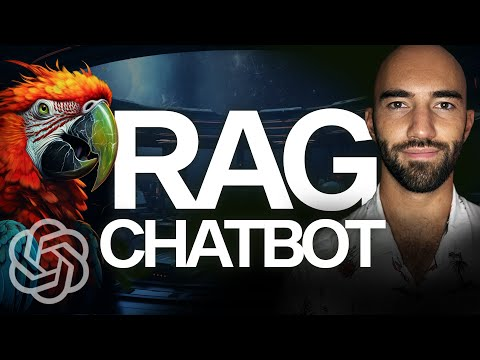

In [ ]:
YouTubeVideo('LhnCsygAvzY')